In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import csv
import numpy as np
import SD2_Model as SD

In [2]:

#net = SD.Net()
device = torch.device("cuda") 
net = SD.Net().to(device)
summary(net, input_size = (1,2))
#print(net)

loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 5]              15
            Linear-2                 [-1, 1, 5]              30
            Linear-3                 [-1, 1, 5]              30
            Linear-4                 [-1, 1, 5]              30
            Linear-5                 [-1, 1, 2]              12
Total params: 117
Trainable params: 117
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [3]:
#dummy data
#trainset = (torch.rand(2,1, device="cuda"), torch.rand(2,1, device="cuda") ) #Xs and Ys
trainset = torch.tensor([[1,2],[3,4]]).to(device)
print(trainset)

tensor([[1, 2],
        [3, 4]], device='cuda:0')


In [4]:
#data = np.loadtxt('../Datasets/2NN_all_dataset.csv' ,delimiter=',', dtype=np.float32)
#print(np.concatenate((data[:,0:1]-256,data[:,1:2]-160), axis=1))

class Coordinates_Dataset(Dataset):
    def __init__(self, datapath):
        #load data
        data = np.loadtxt(datapath ,delimiter=',', dtype=np.float32)
        #feature, data_label = data
        #self.feature = torch.from_numpy(data[:,0:2]).to(device)
        #trying to normailze data
        self.feature = torch.from_numpy(np.concatenate((data[:,0:1]-256,data[:,1:2]-160), axis=1)).to(device)
        self.data_label = torch.from_numpy(data[:,2:4] * 100).to(device) #convert meters to cm
        self.num_samples = data.shape[0]

    def __getitem__(self,index):
        #get data
        #print("index: ",index)
        return self.feature[index],self.data_label[index]


    def __len__(self):
        #len(data)
        return self.num_samples

dataset = Coordinates_Dataset('../Datasets/2NN_all_dataset.csv')
feature, label = dataset[0]
print(feature, label)
trainset = DataLoader(dataset=dataset, batch_size=200, shuffle=True)
#data_iter = iter(trainset)
#print(type(data_iter))
#data = data_iter.next()
#print(data)

## Old data loader
Load_data = False
dataset_path = "../Datasets/2NN_dataset_flight.3.csv"
if(Load_data):
    trainset = []
    with open(dataset_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            #feature, data_label = int(row[0:2]),row[2:4]
            feature, data_label = (int(row[0]),int(row[1])),(float(row[2]) * 100 ,float(row[3]) * 100) #convert to cm
            #feature, data_label = (int(row[0]),int(row[1])),(round(float(row[2]) * 100) ,round(float(row[3]) * 100)) #convert to cm
            trainset.append([feature, data_label])
            #print([feature, data_label])
    trainset = torch.Tensor(trainset).to(device)
    #print(trainset)

test_data = False
if(test_data):
    feature, data_label = trainset[0]
    print(feature, data_label)
    #print(feature.view(1,2))
    output = net(feature)
    print(output)


tensor([ 0., -7.], device='cuda:0') tensor([3.3252, 1.0083], device='cuda:0')


In [5]:
train = True
train =False
epochs = 100
best_loss = 0.0
if (train):
    net.train()
    for epoch in range(epochs):
        for data in trainset:  
            feature, data_label = data #
            #print(data)
            #print(feature)
            #print(data_label)
            net.zero_grad()  
            output = net(feature)
            loss = loss_function(output, data_label) 
            loss.backward() 
            optimizer.step() 
        print(epoch,loss)

0 tensor(857.1874, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(773.9808, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(810.3303, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(680.7107, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(732.3661, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(625.9374, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(499.9648, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(563.5830, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(459.7921, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(482.4962, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(341.5953, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(389.4285, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(294.3290, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(253.0843, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(221.6794, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(85.0146, device='cuda:0', grad_fn=<MseLo

KeyboardInterrupt: 

In [66]:
#save network
save = True
#save = False
model_save_path = "2nd_NN.pt"
if (save):
    torch.save(net, model_save_path)

In [73]:
#test evaluate

Load_eval = False
if(Load_eval):
    #model = SD.Net().to(device)
    net = torch.load("2nd_NN_looks_good.pt")
    net.eval()

dataset_path = "../Datasets/2NN_dataset_eval_data.csv"
if(True):
    net.eval()
    eval_data = Coordinates_Dataset(dataset_path)
    _, datalabel = eval_data[:]
    datalabel_out = datalabel.cpu().detach().numpy()
    model_output = np.empty((0,2))
    for feature, datalabel in eval_data:
        output = net(feature)
        output_cpu = output.cpu().detach().numpy()
        #datalabel_cpu = datalabel.cpu().detach().numpy()
        #print(output_cpu)
        #print(model_output)
        model_output = np.append(model_output,[output_cpu], axis=0)
    #print(model_output)        
             
        

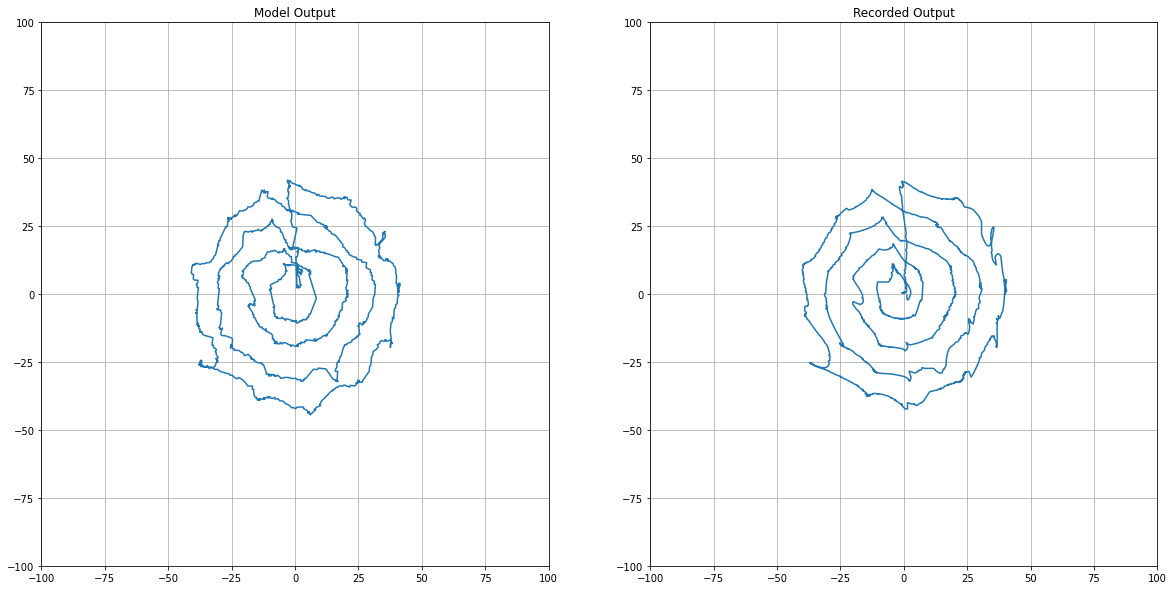

In [74]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(model_output[:,1],model_output[:,0])
ax1.set_xlim([-100, 100])
ax1.set_ylim([-100, 100])
#ax1.set_ylabel('volts')
ax1.set_title('Model Output')
ax1.grid()

ax2.plot(datalabel_out[:,1],datalabel_out[:,0])
ax2.set_xlim([-100, 100])
ax2.set_ylim([-100, 100])
ax2.set_title('Recorded Output')
ax2.grid()

plt.show()